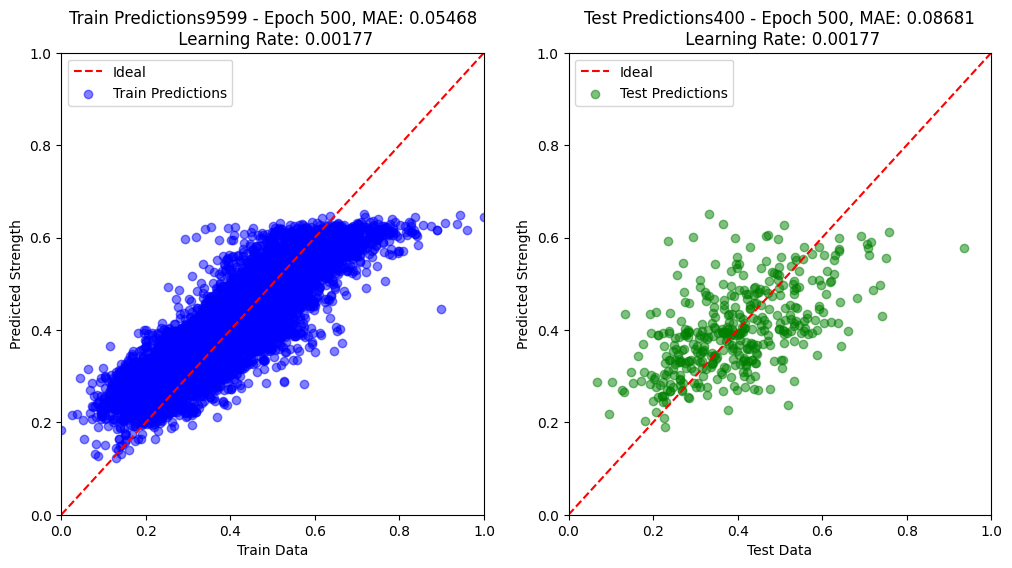

61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - Decode2_loss: 0.0812 - Decode2_mae: 0.2477 - Decode2_mse: 0.0822 - Decode_loss: 0.0216 - Decode_mae: 0.0902 - Decode_mse: 0.0218 - Encode_loss: 0.0061 - Encode_mae: 0.0618 - Encode_mse: 0.0061 - loss: 0.1092 - val_Decode2_loss: 0.0817 - val_Decode2_mae: 0.2482 - val_Decode2_mse: 0.0825 - val_Decode_loss: 0.0196 - val_Decode_mae: 0.0793 - val_Decode_mse: 0.0198 - val_Encode_loss: 0.0101 - val_Encode_mae: 0.0829 - val_Encode_mse: 0.0106 - val_loss: 0.1120 - learning_rate: 0.0018


In [26]:
import numpy as np
import json
import os
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv2D, GlobalAveragePooling2D, Dense, Dropout, Concatenate, Flatten, Reshape,Conv2DTranspose,BatchNormalization,Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from CallBacks import PrintLossCallback, EarlyStoppingByTrainMAE, LiveScatterCNN,LiveScatterThreeOutputs
import tensorflow as tf
from tensorflow.keras.initializers import HeNormal, GlorotUniform
from tensorflow import keras
Iteration=500
lr=0.003
train_size = 0.96
limit=0.02
l2value=0.001
reduceRate=0.9
modelPath="CNN-ANN-4-13.keras"
act="swish"
batch=150
initializer=GlorotUniform()
drop=0.2

# Load node data (25 nodes, 3 features: x, y, z)
with open("nodexy.txt", "r") as file:
    NodeOriginal = json.load(file)
NodeOriginal = np.array(NodeOriginal)  # Convert to NumPy array
# Load element data (features for each sample)
with open("thickness.txt", "r") as file:
    element_features = json.load(file)
element_features = np.array(element_features)  # Convert to NumPy array
# Load target values
energy = np.loadtxt("energy_absorbed.txt")
energy = np.array(energy).reshape(-1, 1)  # Ensure correct shape
minValue=np.argmin(energy)
mask=np.arange((len(energy))) !=minValue
NodeOriginal=NodeOriginal[mask,:,:]
element_features=element_features[mask,:]
energy=energy[mask]
# Extract x, y coordinates
NodeOriginal_x = NodeOriginal[:, :, 0]  # Extract all x-coordinates
NodeOriginal_y = NodeOriginal[:, :, 1]  # Extract all y-coordinates
# Identify and remove edge nodes (x or y = 0 or 30)
_, EdgeNodes = np.where((NodeOriginal_x == 0) | (NodeOriginal_x == 30) | (NodeOriginal_y == 0) | (NodeOriginal_y == 30))
EdgeNodes = np.unique(EdgeNodes)  # Get unique node indices to remove
# Create a mask and filter out edge nodes
mask = np.ones(len(NodeOriginal_x), dtype=bool)
mask[EdgeNodes] = False
filtered_nodes = NodeOriginal[:, :, :]
grid_data_list = []
for sample in filtered_nodes:
    node_positions = sample[:, :2]  # Extract (x, y)
    sorted_indices = np.lexsort((node_positions[:, 0], -node_positions[:, 1]))  # Sort by y (desc), then x (asc)
    sorted_nodes = sample[sorted_indices]  # Reorder nodes spatially
    grid_data = sorted_nodes.reshape(5, 5, 3)  # Convert into 5x5 grid
    grid_data_list.append(grid_data)
node_grid_data = np.array(grid_data_list)

# Normalize data
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
scaler_z = MinMaxScaler()
element_scaler = MinMaxScaler()
energy_scaler = MinMaxScaler()
node_grid_data[:, :, :, 0] = scaler_x.fit_transform(node_grid_data[:, :, :, 0].reshape(-1, 1)).reshape(node_grid_data.shape[:3])
node_grid_data[:, :, :, 1] = scaler_y.fit_transform(node_grid_data[:, :, :, 1].reshape(-1, 1)).reshape(node_grid_data.shape[:3])
node_grid_data[:, :, :, 2] = scaler_z.fit_transform(node_grid_data[:, :, :, 2].reshape(-1, 1)).reshape(node_grid_data.shape[:3])
node_grid_data=node_grid_data[:, : , : , 0:2]
element_features = element_scaler.fit_transform(element_features)
energy = energy_scaler.fit_transform(energy)
print(element_features[:2])
print(node_grid_data[:2])


# Split data into training and testing sets
X_train_nodes, X_test_nodes,X_train_elements, X_test_elements, y_train, y_test = train_test_split(node_grid_data,element_features, energy, test_size=1 - train_size, random_state=42)
print(f"y_train shape: {y_train.shape}") 
print(f"X_train_nodes shape: {X_train_nodes.shape}")

# Define CNN model for node features
node_input = Input(shape=(5,5,2), name="Node_Input")
node_branch = BatchNormalization()(node_input)
node_branch = Conv2D(filters=5, kernel_size=(3,3), padding="same",kernel_initializer=initializer)(node_input)
node_branch = BatchNormalization()(node_branch)  # Apply BN first
node_branch = Activation(act)(node_branch)  # Apply activation after BN
node_branch = Conv2D(filters=10, kernel_size=(3,3), padding="same",kernel_initializer=initializer)(node_branch)
node_branch = BatchNormalization()(node_branch)
node_branch = Activation(act)(node_branch)
node_branch = Conv2D(filters=15, kernel_size=(3,3), padding="same",kernel_initializer=initializer)(node_branch)
node_branch = BatchNormalization()(node_branch)
node_branch = Activation(act)(node_branch)
node_branch = GlobalAveragePooling2D()(node_branch)
 # Reduce to 1D
element_input = Input(shape=(X_train_elements.shape[1],), name="Element_Input")
element_branch = Dense(100, activation="swish",kernel_initializer=initializer)(element_input)
element_branch = Dropout(drop)(element_branch)
element_branch = Dense(90, activation="swish",kernel_initializer=initializer)(element_branch)
element_branch = Dropout(drop)(element_branch)
element_branch = Dense(80, activation="swish",kernel_initializer=initializer)(element_branch)
element_branch = Dropout(drop)(element_branch)
element_branch = Dense(75, activation="swish",kernel_initializer=initializer)(element_branch)
element_branch = Dropout(drop)(element_branch)
element_branch = Dense(50, activation="swish",kernel_initializer=initializer)(element_branch)
element_branch = Dropout(drop)(element_branch)
element_branch = Dense(30, activation="swish",kernel_regularizer=l2(l2value))(element_branch)


# Concatenate CNN and ANN features
merged = Concatenate()([node_branch, element_branch])
latentSpace=Dense(100,activation=act,kernel_initializer=initializer)(merged)
latentSpace=Dropout(drop)(latentSpace)
latentSpace=Dense(80,activation=act,kernel_initializer=initializer)(latentSpace)
latentSpace=Dropout(drop)(latentSpace)
latentSpace=Dense(80,activation=act,kernel_initializer=initializer)(latentSpace)
latentSpace=Dropout(drop)(latentSpace)
latentSpace=Dense(80,activation=act,kernel_initializer=initializer)(latentSpace)
latentSpace=Dropout(drop)(latentSpace)
latentSpace=Dense(70,activation=act,kernel_initializer=initializer)(latentSpace)
latentSpace=Dropout(drop)(latentSpace)
latentSpace=Dense(50,activation=act,kernel_initializer=initializer)(latentSpace)
latentSpace=Dropout(drop)(latentSpace)
latentSpace=Dense(30,activation=act,kernel_initializer=initializer)(latentSpace)
latentSpace=Dropout(drop)(latentSpace)
latentSpace=Dense(15,kernel_initializer=initializer,name="Latent",kernel_regularizer=l2(l2value))(latentSpace)
encoded = Dense(10,kernel_initializer=initializer,kernel_regularizer=l2(l2value))(latentSpace)
encoded = Dense(5,kernel_initializer=initializer)(encoded)
encode = Dense(1, activation="linear", name="Encode")(encoded)

decoded = Dense(30,kernel_initializer=initializer,kernel_regularizer=l2(l2value))(latentSpace)
decoded = Dense(40,kernel_initializer=initializer)(decoded)
decoded = Dropout(drop)(decoded)
decoded = Dense(50, activation=act,kernel_initializer=initializer)(decoded)
decoded = Dropout(drop)(decoded)
decoded = Dense(25*2, activation=act,kernel_initializer=initializer)(decoded)
decoded = Dropout(drop)(decoded)
decoded = Reshape((5,5,2))(decoded)
decoded = Conv2DTranspose(6, kernel_size=(3,3), activation=act, padding="same",kernel_initializer=initializer)(decoded)
decode = Conv2DTranspose(2, kernel_size=(3,3), activation=act, padding="same",kernel_initializer=initializer,name="Decode")(decoded)
#decode = Reshape((5,5,7), name="Decode")(decoded)

decoded2= Dense(12,kernel_initializer=initializer, kernel_regularizer=l2(l2value))(latentSpace)
decoded2= Dense(24,kernel_initializer=initializer,kernel_regularizer=l2(l2value))(decoded2)
decoded2= Dense(36,kernel_initializer=initializer,name="Decode2")(decoded2)

def log_cosh_loss(y_true, y_pred):
    return tf.reduce_mean(tf.math.log(tf.cosh(y_pred - y_true)))

def combinedloss(y_true,y_pred):
    logc=log_cosh_loss(y_true,y_pred)
    huber=tf.keras.losses.Huber()
    huber_loss=huber(y_true,y_pred)
    return logc+huber_loss

# Create model
if os.path.exists(modelPath):
    print("Loading model")
    model=load_model(modelPath,custom_objects={"combinedloss": combinedloss, "log_cosh_loss": log_cosh_loss})
else:
    print("Creating model")
    model = Model(inputs=[node_input,element_input], outputs=[encode,decode,decoded2])


model.compile(optimizer=Adam(learning_rate=lr), 
              loss={"Encode": combinedloss, "Decode":combinedloss, "Decode2":combinedloss},
              #loss_weights={"Encode": 0.5, "Decode": 0.5},
              metrics={"Encode": ["mae", "mse"], "Decode": ["mae", "mse"],"Decode2": ["mae", "mse"]})

# Define callbacks for early stopping and learning rate reduction
checkpoint = ModelCheckpoint(modelPath, monitor="val_Encode_mae", save_best_only=True, mode="min", verbose=0)
reduce_lr = ReduceLROnPlateau(monitor="Encode_mae", factor=reduceRate, patience=30, min_lr=1e-7, verbose=0)
X_train_nodes = np.array(X_train_nodes, dtype=np.float32)
LossMonitor = PrintLossCallback("Encode_mae",interval=10)
early_stopping = EarlyStoppingByTrainMAE("Encode_mae",threshold=limit)
plot=LiveScatterThreeOutputs(X_train_nodes,X_test_nodes,X_train_elements,X_test_elements, y_train, y_test, interval=10)

print(f"Model output shapes: {[o.shape for o in model.outputs]}")
print(f"y_train shape: {y_train.shape}") 
print(f"X_train_nodes shape: {X_train_nodes.shape}")
print("Target Min:", np.min(y_train), "Target Max:", np.max(y_train))
# Train model
history = model.fit(
    [X_train_nodes,X_train_elements],
    [y_train, X_train_nodes,X_train_elements],
    epochs=Iteration,
    batch_size=batch,
    validation_split=0.05,
    callbacks=[checkpoint,reduce_lr,LossMonitor,plot],
    verbose=1
)
